## Table of Contents

1. [Import Libraries](#1)<br>
2. [Inception Model](#2)<br>
3. [ResNet Model](#3)<br>

# 🟢Import Libraries <a id ="1" ><a>

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [ ]:
import PIL
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam ,SGD
from sklearn.metrics import mean_squared_error as MSE_SKL
from sklearn.metrics import mean_absolute_error as MAE_SKL
from tensorflow.keras.metrics import mean_absolute_error as MAE_TF
from tensorflow.keras.regularizers import L2

In [ ]:
print(plt.style.available)
plt.style.use('ggplot')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


## 🟢 Create Training Data  

In [ ]:
train_inputImg = pd.read_csv('../input/cephalometric-landmarks/train_senior.csv', delimiter=',')

train_images = []
train_images_rgb_blured = []

train_images_hsv = []
train_images_hsv_blured  = []

train_coords=[]



for row in train_inputImg.values:
    image_object = list(row)
    coords = image_object[1:]
    train_x_1_coord = []
    train_y_1_coord = []
    for i in range(0,len(coords)-1,2):
        train_x_1_coord.append((coords[i])/10)
        train_x_1_coord.append((coords[i+1])/10)
    train_coords.append(np.array(train_x_1_coord))
    
    gray_image = cv2.imread('../input/cephalometric-landmarks/cepha400/cepha400/' + image_object[0],cv2.IMREAD_GRAYSCALE ) 
    #print(gray_image.shape)
    gray_resized_image = cv2.resize(gray_image,(193,240))
    gray_resized_image = cv2.normalize(gray_resized_image, None, 0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    #print(f"max = {np.max(gray_resized_image,axis=0)} , min = {np.min(gray_resized_image,axis=0)} ")
    rgb_resized_image = cv2.cvtColor(gray_resized_image,cv2.COLOR_GRAY2RGB)
    blured_rgb_resized_image = cv2.blur(rgb_resized_image,(3,3))
    
    hsv_resized_image = cv2.cvtColor(rgb_resized_image, cv2.COLOR_BGR2HSV)
    blured_hsv_resized_image = cv2.blur(hsv_resized_image ,(3,3))
    
    train_images.append(rgb_resized_image)
    train_images_rgb_blured.append(blured_rgb_resized_image)
    
    train_images_hsv.append(hsv_resized_image)
    train_images_hsv_blured.append(blured_hsv_resized_image)
    

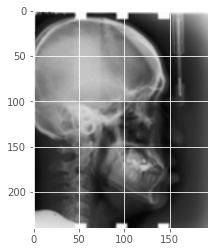

In [ ]:
blur = cv2.blur(train_images[0],(3,3))
plt.imshow(blur)

In [ ]:
print("Type of train_images", type(train_images))
print("Shape of Training Images",(np.array(train_images).shape),"\n")

print("Type of train_images", type(train_images_hsv))
print("Shape of Training Images",(np.array(train_images_hsv).shape),"\n")

print("Type of train_coords", type(train_coords))
print("Shape of train_coords",(np.array(train_coords).shape))

Type of train_images <class 'list'>
Shape of Training Images (150, 240, 193, 3) 

Type of train_images <class 'list'>
Shape of Training Images (150, 240, 193, 3) 

Type of train_coords <class 'list'>
Shape of train_coords (150, 38)


## 🟢 Create Validation Data  

In [ ]:
val_inputImg = pd.read_csv('../input/cephalometric-landmarks/test1_senior.csv', delimiter=',')
val_images = []
train_images_rgb_blured = []
train_images_hsv_blured  = []


val_images_hsv = []
val_images_rgb_blured = []
val_images_hsv_blured  = []

val_coords = []

count = 1

for row in val_inputImg.values:
    image_object = list(row)
    coords = image_object[1:]
    train_x_1_coord = []
    train_y_1_coord = []
    val_x_1_coord = []
    val_y_1_coord = []
    
    gray_image = cv2.imread('../input/cephalometric-landmarks/cepha400/cepha400/' + image_object[0],cv2.IMREAD_GRAYSCALE ) 
    gray_resized_image = cv2.resize(gray_image,(193,240))
    gray_resized_image = cv2.normalize(gray_resized_image, None, 0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    rgb_resized_image = cv2.cvtColor(gray_resized_image,cv2.COLOR_GRAY2RGB)
    blured_rgb_resized_image = cv2.blur(rgb_resized_image,(3,3))
    
    hsv_resized_image = cv2.cvtColor(rgb_resized_image, cv2.COLOR_BGR2HSV)
    blured_hsv_resized_image = cv2.blur(hsv_resized_image ,(3,3))
    
    if count <= 100:
            train_images.append(rgb_resized_image)
            train_images_hsv.append(hsv_resized_image)
            train_images_rgb_blured.append(blured_rgb_resized_image)
            train_images_hsv_blured.append(blured_hsv_resized_image)

    else:
            val_images.append(rgb_resized_image)
            val_images_hsv.append(hsv_resized_image)
            val_images_rgb_blured.append(blured_rgb_resized_image)
            val_images_hsv_blured.append(blured_hsv_resized_image)
            
    for i in range(0,len(coords)-1,2):
        
        if count <= 100:
            train_x_1_coord.append((coords[i])/10)
            train_x_1_coord.append((coords[i+1])/10)
        
        else:
            val_x_1_coord.append((coords[i])/10)
            val_x_1_coord.append((coords[i+1])/10)
    if count<=100:
        train_coords.append(np.array(train_x_1_coord))
    else:
        val_coords.append(np.array(val_x_1_coord))

    
    count += 1
    

In [ ]:
print("Type of val_images", type(val_images))
print("Shape of val_images ",(np.array(val_images).shape),"\n")

print("Type of val_images", type(val_images_hsv))
print("Shape of val_images ",(np.array(val_images_hsv).shape),"\n")

print("Type of val_coords", type(val_coords))
print("Shape of val_coords",(np.array(val_coords).shape))

Type of val_images <class 'list'>
Shape of val_images  (50, 240, 193, 3) 

Type of val_images <class 'list'>
Shape of val_images  (50, 240, 193, 3) 

Type of val_coords <class 'list'>
Shape of val_coords (50, 38)


## 🟢 Import Testing Data

In [ ]:
test_inputImg = pd.read_csv('../input/cephalometric-landmarks/test2_senior.csv', delimiter=',')
test_images = []
test_images_rgb_blured = []

test_images_hsv = []
test_images_hsv_blured = []

test_coords = []

count =1

for row in test_inputImg.values:
    image_object = list(row)
    coords = image_object[1:]
    test_x_1_coord = []
    train_x_1_coord = []
    for i in range(0,len(coords)-1,2):
        if count <=50:
            train_x_1_coord.append((coords[i])/10)
            train_x_1_coord.append((coords[i+1])/10)
            
        else:
            test_x_1_coord.append((coords[i])/10)
            test_x_1_coord.append((coords[i+1])/10)
            
    if count<=50:
        train_coords.append(np.array(train_x_1_coord))
    else:
        test_coords.append(np.array(test_x_1_coord))
    gray_image = cv2.imread('../input/cephalometric-landmarks/cepha400/cepha400/' + image_object[0],cv2.IMREAD_GRAYSCALE ) 
    gray_resized_image = cv2.resize(gray_image,(193,240))
    gray_resized_image = cv2.normalize(gray_resized_image, None, 0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    rgb_resized_image = cv2.cvtColor(gray_resized_image,cv2.COLOR_GRAY2RGB)
    blured_rgb_resized_image = cv2.blur(rgb_resized_image,(3,3))
    
    hsv_resized_image = cv2.cvtColor(rgb_resized_image, cv2.COLOR_BGR2HSV)
    blured_hsv_resized_image = cv2.blur(hsv_resized_image ,(3,3))
    
        
    if count <= 50:
            train_images.append(rgb_resized_image)
            train_images_hsv.append(hsv_resized_image)
            train_images_rgb_blured.append(blured_rgb_resized_image)
            train_images_hsv_blured.append(blured_hsv_resized_image)
    
    else:
            test_images.append(rgb_resized_image)
            test_images_rgb_blured.append(blured_rgb_resized_image)
            test_images_hsv.append(hsv_resized_image)
            test_images_hsv_blured.append(blured_hsv_resized_image)
        
    count += 1

In [ ]:
print("Type of test_images", type(test_images))
print("Shape of test_images ",(np.array(test_images).shape),"\n")

print("Type of test_images", type(test_images_hsv))
print("Shape of test_images ",(np.array(test_images_hsv).shape),"\n")

print("Type of test_coords", type(test_coords))
print("Shape of test_coords",(np.array(test_coords).shape))

Type of test_images <class 'list'>
Shape of test_images  (50, 240, 193, 3) 

Type of test_images <class 'list'>
Shape of test_images  (50, 240, 193, 3) 

Type of test_coords <class 'list'>
Shape of test_coords (50, 38)


## Final Sets Shape 

In [ ]:
print("********* Training Set *********")
print("Shape of Training Images",(np.array(train_images).shape),"\n")
print("Shape of Training Images",(np.array(train_images_hsv).shape),"\n")
print("Shape of train_coords",(np.array(train_coords).shape),"\n")

print("********* Validation Set *********")
print("Shape of val_images ",(np.array(val_images).shape),"\n")
print("Shape of test_images ",(np.array(val_images_hsv).shape),"\n")
print("Shape of val_coords",(np.array(val_coords).shape),"\n")

print("********* Test Set *********")
print("Shape of test_images ",(np.array(test_images).shape),"\n")
print("Shape of test_images ",(np.array(test_images_hsv).shape),"\n")
print("Shape of test_coords",(np.array(test_coords).shape))



********* Training Set *********
Shape of Training Images (300, 240, 193, 3) 

Shape of Training Images (300, 240, 193, 3) 

Shape of train_coords (300, 38) 

********* Validation Set *********
Shape of val_images  (50, 240, 193, 3) 

Shape of test_images  (50, 240, 193, 3) 

Shape of val_coords (50, 38) 

********* Test Set *********
Shape of test_images  (50, 240, 193, 3) 

Shape of test_images  (50, 240, 193, 3) 

Shape of test_coords (50, 38)


In [ ]:
np.array(train_coords).shape

(300, 38)

## 🟢 Stack Training Data

In [ ]:
train_images_stacked = np.stack(train_images, axis=0)
train_images_rgb_blured_stacked = np.stack(train_images_rgb_blured, axis=0)


train_images_hsv_stacked = np.stack(train_images_hsv, axis=0)
train_images_hsv_blured_stacked = np.stack(train_images_hsv_blured, axis=0)



train_labels = np.array(train_coords)

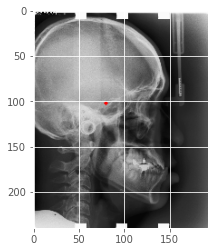

In [ ]:
img = cv2.circle(train_images_stacked[0], (int(train_labels[0][0]),int(train_labels[0][1])), 2, (255,0,0),-1)
plt.imshow(img)


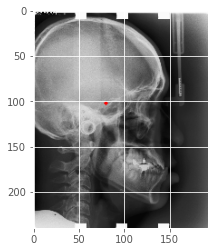

In [ ]:
img_ = cv2.circle(train_images_stacked[0], (800,1080), 25, (255,0,0),-1)
plt.imshow(img_)

## 🟢 Stack Validation Data

In [ ]:
val_images_stacked= np.stack(val_images, axis=0)
val_images_rgb_blured_stacked= np.stack(val_images_rgb_blured, axis=0)


val_images_hsv_stacked= np.stack(val_images_hsv, axis=0)
val_images_hsv_blured_stacked= np.stack(val_images_hsv_blured, axis=0)

val_labels = np.array(val_coords)

val_data = (val_images_stacked,val_labels)
val_data_rgb_blured = (val_images_rgb_blured_stacked,val_labels)                                        

val_data_hsv = (val_images_hsv_stacked,val_labels)
val_data_hsv_blured = (val_images_hsv_blured_stacked,val_labels)



## 🟢 Stack Test Data

In [ ]:
test_images_stacked= np.stack(test_images, axis=0)
test_images_rgb_blured_stacked= np.stack(test_images_rgb_blured, axis=0)

test_images_hsv_stacked= np.stack(test_images_hsv, axis=0)
test_images_hsv_blured_stacked= np.stack(test_images_hsv_blured, axis=0)


test_labels = np.array(test_coords)

## Final Stacked Shape

In [ ]:
print("********* Stacked Training Set *********")
print("Type of train_images_stacked",(type(train_images_stacked)))
print("Shape of train_images_stacked",((train_images_stacked).shape))
# print("Shape of train_images_stacked",((train_images_rgb_blured_stacked).shape))
# print("Shape of train_images_stacked",((train_images_hsv_blured_stacked).shape))
print("Type of train_labels",(type(train_labels)))
print("Shape of train_labels",((train_labels).shape),"\n")

print("********* Stacked Validation Set *********")
print("Shape of val_images_stacked ",((val_images_stacked).shape))
print("Shape of val_labels",((val_labels).shape))
print("Val_datet => (val_labels,val_labels)")
print("Type of val_data",(type(val_data)),"\n")

print("********* Stacked Test Set *********")
print("Type of test_labels",(type(test_labels)))
print("Shape of test_images_stacked ",((test_images_stacked).shape))
print("Type of test_labels",(type(test_labels)))
print("Shape of test_labels",((test_labels).shape))

********* Stacked Training Set *********
Type of train_images_stacked <class 'numpy.ndarray'>
Shape of train_images_stacked (300, 240, 193, 3)
Type of train_labels <class 'numpy.ndarray'>
Shape of train_labels (300, 38) 

********* Stacked Validation Set *********
Shape of val_images_stacked  (50, 240, 193, 3)
Shape of val_labels (50, 38)
Val_datet => (val_labels,val_labels)
Type of val_data <class 'tuple'> 

********* Stacked Test Set *********
Type of test_labels <class 'numpy.ndarray'>
Shape of test_images_stacked  (50, 240, 193, 3)
Type of test_labels <class 'numpy.ndarray'>
Shape of test_labels (50, 38)


# Radial Error Loss Metric

## Mean Radial Error For each Landmark

In [ ]:
def mean_radial_error_landmark(x_true,y_true,x_pred,y_pred):
    delta_x_2 =  np.power( ( np.subtract(x_true , x_pred) ) , 2) #(2,4)
    delta_y_2 =  np.power( ( np.subtract(y_true, y_pred ) ) , 2) #(2,4)

    radial_error_lm_ex = np.sqrt(np.add(delta_x_2,delta_y_2)) #(2,4)

#     print(radial_error_lm_ex)

    radial_error_lm = np.sum(radial_error_lm_ex, axis = 0,keepdims=True) #(1,4)
#     print(radial_error_lm)

    mean_radial_error_lm = radial_error_lm / x_true.shape[0]
    print(x_true.shape[0])
    
    return radial_error_lm_ex,mean_radial_error_lm

## 🔵 Create InceptionResNetV2 Model  <a id="2"></a>

In [ ]:
from keras.models import Model

pretrained_model= tf.keras.applications.InceptionResNetV2(include_top=False,
                   input_shape=(240,193,3),                    
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False
# add a global spatial average pooling layer
x = pretrained_model.output
x =  tf.keras.layers.Flatten()(x)
# let's add a fully-connected layer
x =Dropout(0.2)(x)
x = Dense(1024, activation='relu', kernel_initializer = 'he_uniform')(x)
x =Dropout(0.2)(x)
# x = Dense(512, activation='relu', kernel_initializer = 'he_uniform')(x)
# # x =Dropout(0.3)(x)
# x = Dense(256, activation='relu', kernel_initializer = 'he_uniform')(x)
# x =Dropout(0.3)(x)
# and a linear output layer
prediction = Dense(38, activation='linear')(x)
# this is the model we will train
InceptionResNetV2 = Model(inputs=pretrained_model.input, outputs=prediction)


2023-01-02 21:29:21.028277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 21:29:21.188443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 21:29:21.189247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 21:29:21.191082: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

219070464/219055592 [==============================] - 7s 0us/step


## 🔵 Compile Model

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
                                                patience=5,
                                                min_delta=0.001)

InceptionResNetV2.compile(optimizer=Adam(learning_rate=0.0001),loss='mae',metrics=['mae'])

## 🔵 Fit Model

In [ ]:
start_time = time.time()
history = InceptionResNetV2.fit(train_images_stacked,train_labels, validation_data = val_data, epochs=500, batch_size=64)
end_time = time.time()
print("Training_time:",end_time-start_time)

Epoch 1/500
5/5 [==============================] - 14s 1s/step - loss: 126.3086 - mae: 126.3086 - val_loss: 99.3024 - val_mae: 99.3024
Epoch 2/500
5/5 [==============================] - 1s 213ms/step - loss: 85.2789 - mae: 85.2789 - val_loss: 57.1935 - val_mae: 57.1935
Epoch 3/500
5/5 [==============================] - 1s 220ms/step - loss: 52.3687 - mae: 52.3687 - val_loss: 29.4138 - val_mae: 29.4138
Epoch 4/500
5/5 [==============================] - 1s 210ms/step - loss: 36.6305 - mae: 36.6305 - val_loss: 20.1604 - val_mae: 20.1604
Epoch 5/500
5/5 [==============================] - 1s 211ms/step - loss: 33.8449 - mae: 33.8449 - val_loss: 20.5308 - val_mae: 20.5308
Epoch 6/500
5/5 [==============================] - 1s 211ms/step - loss: 31.6926 - mae: 31.6926 - val_loss: 18.6012 - val_mae: 18.6012
Epoch 7/500
5/5 [==============================] - 1s 211ms/step - loss: 28.4079 - mae: 28.4079 - val_loss: 16.7971 - val_mae: 16.7971
Epoch 8/500
5/5 [==============================] - 1s 2

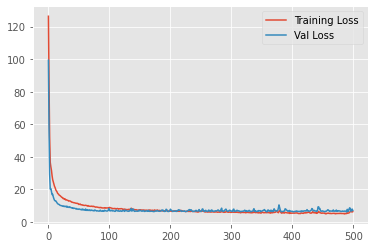

In [ ]:
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Val Loss")
plt.legend()
plt.show()

## 🔵 Make Predictions


In [ ]:
start_time = time.time()

prediction_IncepRes=InceptionResNetV2.predict(test_images_stacked)

end_time =  time.time()

print("prediction_time:",end_time-start_time)


prediction_time: 3.658173084259033


In [ ]:
MAE_SKL(test_labels, prediction_IncepRes)

8.282225678293328

In [ ]:
x_coored_ind = np.arange(start=0, stop=38, step=2)
y_coored_ind = np.arange(start=1, stop=39, step=2)

x_true = test_labels[:,x_coored_ind]
y_true = test_labels[:,y_coored_ind]

x_pred_incep = prediction_IncepRes[:,x_coored_ind]
y_pred_incep = prediction_IncepRes[:,y_coored_ind]

mre_each_lm_incep=(mean_radial_error_landmark(x_true,y_true,x_pred_incep,y_pred_incep)).reshape(19)

In [ ]:
delta_x_incep = ( np.subtract(x_true , x_pred_incep) )
delta_x_lm_incep = np.sum(delta_x_incep, axis = 0,keepdims=True)/100
difference_x_incep=(delta_x_lm_incep).reshape(19)

delta_y_incep = ( np.subtract(y_true , y_pred_incep) )
delta_y_lm_incep = np.sum(delta_y_incep, axis = 0,keepdims=True)/100
difference_y_incep =(delta_y_lm_incep).reshape(19)

In [ ]:
landmark = np.array(np.arange(1,20),dtype=int)
import pandas as pd

results_incep = pd.DataFrame({"landmark":landmark,
                        "Mean Radial Error":mre_each_lm_incep,
                        "X_true - X_pred":difference_x_incep,
                        "y_true - y_pred":difference_y_incep})
results_incep.set_index(['landmark'])

In [ ]:
for i in range(len(test_labels)):
    print(f'mae of image {i}  = {mean_absolute_error(test_labels[i], prediction_IncepRes[i])}')

In [ ]:
img_number = 56
img = np.copy(test_images_stacked[img_number])
for i in range(0,len(test_labels[img_number])-1,2):
    img = cv2.circle(img, (int(test_labels[img_number][i]),int(test_labels[img_number][i+1])), 2, (255,0,0),-1)
    img = cv2.circle(img, (int(prediction_IncepRes[img_number][i]),int(prediction_IncepRes[img_number][i+1])), 2, (0,255,0),-1)
plt.imshow(img)

In [ ]:
img_number = 55
img = np.copy(test_images_stacked[img_number])
for i in range(0,len(test_labels[img_number])-1,2):
    img = cv2.circle(img, (int(test_labels[img_number][i]),int(test_labels[img_number][i+1])), 2, (255,0,0),-1)
    img = cv2.circle(img, (int(prediction_IncepRes[img_number][i]),int(prediction_IncepRes[img_number][i+1])), 2, (0,255,0),-1)
plt.imshow(img)

In [ ]:
img_number = 68
img = np.copy(test_images_stacked[img_number])
for i in range(0,len(test_labels[4])-1,2):
    img = cv2.circle(img, (int(test_labels[img_number][i]),int(test_labels[img_number][i+1])), 2, (255,0,0),-1)
    img = cv2.circle(img, (int(prediction_IncepRes[img_number][i]),int(prediction_IncepRes[img_number][i+1])), 2, (0,255,0),-1)
plt.imshow(img)

In [ ]:
InceptionResNetV2.save('incep_adabtiveLR.h5')

In [ ]:
from IPython.display import FileLink
FileLink("./incep_adabtiveLR.h5")

## 🟡 K-fold Cross validation<a id="3"></a>

In [ ]:
inputs = np.concatenate((train_images_stacked, val_images_stacked), axis=0)
targets = np.concatenate((train_labels, val_labels), axis=0)
print(inputs.shape)
print(targets.shape)

(300, 240, 193, 3)
(300, 38)


In [ ]:
from sklearn.model_selection import KFold
from keras.models import Model
import tensorflow_addons as tfa
# Merge inputs and targets
inputs = np.concatenate((train_images_stacked, val_images_stacked), axis=0)
targets = np.concatenate((train_labels, val_labels), axis=0)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)
# K-fold Cross Validation model evaluation
fold_no = 1
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
for train, val in kfold.split(inputs, targets):
  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
#   history = model.fit(inputs[train], targets[train],
#               batch_size=batch_size,
#               epochs=no_epochs,
#               verbose=verbosity)


    pretrained_model= tf.keras.applications.InceptionResNetV2(include_top=False,
                       input_shape=(240,193,3),
                        pooling='avg',
                       weights='imagenet')
    for layer in pretrained_model.layers:
            layer.trainable=False
    # add a global spatial average pooling layer
    x = pretrained_model.output
    x =  tf.keras.layers.Flatten()(x)
    x =Dropout(0.25)(x)
    x = Dense(1024, activation='relu',kernel_initializer = 'he_normal')(x)
#     x =Dropout(0.25)(x)
    x = Dense(512, activation='relu',kernel_initializer = 'he_normal')(x)
#     x =Dropout(0.25)(x)
    x = Dense(256, activation='relu',kernel_initializer = 'he_normal')(x)
#     x =Dropout(0.25)(x)
    x = Dense(128, activation='relu',kernel_initializer = 'he_normal')(x)
    x =Dropout(0.25)(x)
    # and a linear output layer
    prediction = Dense(38, activation='linear')(x)
    # this is the model we will train
    InceptionResNetV2 = Model(inputs=pretrained_model.input, outputs=prediction)
    clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=10e-4,
    maximal_learning_rate=0.1,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * 32)
    
    InceptionResNetV2.compile(optimizer=Adam(clr),loss='mae',metrics=['mae'])
    history = InceptionResNetV2.fit(inputs[train], targets[train], validation_data = (inputs[val], targets[val]), batch_size = 32,epochs=400) 

  # Generate generalization metrics
    scores = InceptionResNetV2.evaluate(test_images_stacked, test_labels, verbose=0)
    print(f'Score for fold {fold_no}: {InceptionResNetV2.metrics_names[0]} of {scores[0]}; {InceptionResNetV2.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    InceptionResNetV2.save(f"InceptionV2_fold{fold_no}")

  # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

In [ ]:
from sklearn.model_selection import KFold
from keras.models import Model
import tensorflow_addons as tfa
# Merge inputs and targets
inputs = np.concatenate((train_images_stacked, val_images_stacked), axis=0)
targets = np.concatenate((train_labels, val_labels), axis=0)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)
# K-fold Cross Validation model evaluation
fold_no = 1
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
for train, val in kfold.split(inputs, targets):
  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    pretrained_model2= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(240,193,3),                    
                   weights='imagenet')

    for layer_no , layer in zip(range(1,len(pretrained_model2.layers)+1),pretrained_model2.layers): #176 Layers
    #     if layer_no > 172:
    #         layer.trainable=True
    #     else:
            layer.trainable=False

    #     print(layer_no)
    x = pretrained_model2.output
    x =  tf.keras.layers.Flatten()(x)

#     initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.) #kernel_initializer=initializer


    # x = Dense(2048, activation='relu', kernel_initializer = 'he_uniform')(x)
    # x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu', kernel_initializer = 'he_uniform')(x)
    # x =Dropout(0.2)(x)
    x = Dense(512, activation='relu', kernel_initializer = 'he_uniform')(x)
    # # x =Dropout(0.25)(x)
    x = Dense(256, activation='relu', kernel_initializer = 'he_uniform')(x)
    # # x =Dropout(0.25)(x)
    # x = Dense(128, activation='relu', kernel_initializer = 'he_normal')(x)
    # # x =Dropout(0.25)(x)

    #x = Dense(512, activation='relu',kernel_initializer=initializer)(x)
    # x =Dropout(0.2)(x)
    # x = Dense(128, activation='relu', kernel_initializer = 'he_uniform')(x)
    # x =Dropout(0.2)(x)
    x = Dense(64, activation='relu', kernel_initializer = 'he_uniform')(x)
    prediction = Dense(38, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(x)

    resnet50_model = Model(inputs=pretrained_model2.input, outputs=prediction)
    checkpoint_filepath = '/resnet/checkpoint'
    resnet_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
    resnet50_model.compile(optimizer=Adam(learning_rate = 0.0001),loss='mae',metrics=['mae'])
    start_time = time.time()

    history = resnet50_model.fit(inputs[train], targets[train], validation_data = (inputs[val], targets[val]), epochs=500,batch_size =64,callbacks=[resnet_model_checkpoint_callback])

    end_time =  time.time()

    print("Training_time: ",end_time-start_time )


  # Generate generalization metrics
    scores = resnet50_model.evaluate(test_images_stacked, test_labels, verbose=0)
    print(f'Score for fold {fold_no}: {resnet50_model.metrics_names[0]} of {scores[0]}; {resnet50_model.metrics_names[1]} of {scores[1]}%')
    acc_per_fold.append(scores[1] )
    loss_per_fold.append(scores[0])
    resnet50_model.save(f"resnet50_model_fold{fold_no}.h5")

  # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...


2023-01-01 15:19:59.142770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 15:19:59.230284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 15:19:59.231060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 15:19:59.232590: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step


2023-01-01 15:20:03.954955: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2023-01-01 15:20:07.681495: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4/4 [==============================] - 11s 652ms/step - loss: 136.9477 - mae: 136.9477 - val_loss: 127.1136 - val_mae: 127.1136
Epoch 2/500
4/4 [==============================] - 1s 190ms/step - loss: 122.2846 - mae: 122.2846 - val_loss: 111.4356 - val_mae: 111.4356
Epoch 3/500
4/4 [==============================] - 1s 164ms/step - loss: 105.3999 - mae: 105.3999 - val_loss: 92.6552 - val_mae: 92.6552
Epoch 4/500
4/4 [==============================] - 1s 151ms/step - loss: 89.2697 - mae: 89.2697 - val_loss: 82.8978 - val_mae: 82.8978
Epoch 5/500
4/4 [==============================] - 1s 176ms/step - loss: 81.7104 - mae: 81.7104 - val_loss: 77.9764 - val_mae: 77.9764
Epoch 6/500
4/4 [==============================] - 1s 157ms/step - loss: 75.9772 - mae: 75.9772 - val_loss: 71.9182 - val_mae: 71.9182
Epoch 7/500
4/4 [==============================] - 1s 159ms/step - loss: 70.0776 - mae: 70.0776 - val_loss: 65.5302 - val_mae: 65.5302
Epoch 8/500
4/4 [==============================] - 1s 15

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/500
4/4 [==============================] - 5s 444ms/step - loss: 136.4953 - mae: 136.4953 - val_loss: 127.9383 - val_mae: 127.9383
Epoch 2/500
4/4 [==============================] - 1s 153ms/step - loss: 121.6033 - mae: 121.6033 - val_loss: 112.7332 - val_mae: 112.7332
Epoch 3/500
4/4 [==============================] - 1s 155ms/step - loss: 106.2028 - mae: 106.2028 - val_loss: 96.0962 - val_mae: 96.0962
Epoch 4/500
4/4 [==============================] - 1s 151ms/step - loss: 89.3251 - mae: 89.3251 - val_loss: 80.1598 - val_mae: 80.1598
Epoch 5/500
4/4 [==============================] - 1s 156ms/step - loss: 77.4878 - mae: 77.4878 - val_loss: 73.3294 - val_mae: 73.3294
Epoch 6/500
4/4 [==============================] - 1s 154ms/step - loss: 70.1648 - mae: 70.1648 - val_loss: 65.3241 - val_mae: 65.3241
Epoch 7/500
4/4 [==============================] - 1s 153ms/step - loss: 62.4156 - 

## 🟡 Create ResNet50 model <a id="3"></a>

In [ ]:
from keras.models import Model
import tensorflow_addons as tfa
pretrained_model2= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(240,193,3),                    
                   weights='imagenet')

for layer_no , layer in zip(range(1,len(pretrained_model2.layers)+1),pretrained_model2.layers): #176 Layers
#     if layer_no > 172:
#         layer.trainable=True
#     else:
        layer.trainable=False
    
#     print(layer_no)
x = pretrained_model2.output
x =  tf.keras.layers.Flatten()(x)


# x = Dropout(0.2)(x)
# x = Dense(2048, activation='relu', kernel_initializer = 'he_uniform')(x)
# x = Dropout(0.2)(x)
x = Dense(1024, activation='relu', kernel_initializer = 'he_uniform')(x)
# x =Dropout(0.2)(x)
# x = Dense(512, activation='relu', kernel_initializer = 'he_uniform')(x)
# x =Dropout(0.25)(x)
# x = Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer = 'he_uniform')(x)
# # x =Dropout(0.25)(x)
# x = Dense(128, activation='relu', kernel_initializer = 'he_normal')(x)
# # x =Dropout(0.25)(x)
# x = Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.3), kernel_initializer = 'he_uniform')(x)
prediction = Dense(38, activation='linear')(x)

resnet50_model = Model(inputs=pretrained_model2.input, outputs=prediction)


In [ ]:
resnet50_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 240, 193, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 246, 199, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 120, 97, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 120, 97, 64)  256         conv1_conv[0][0]                 
____________________________________________________________________________________________

## 🟡 Adabtive Learning Rate

In [ ]:
!pip install -q -U tensorflow_addons

In [ ]:
import tensorflow_addons as tfa
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=10e-2,
    maximal_learning_rate=0.5,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * 64
)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
                                                patience=5,
                                                min_delta=0.02)

In [ ]:
checkpoint_filepath = '/resnet/checkpoint'

resnet_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

## 🟡 Compile Model

In [ ]:
resnet50_model.compile(optimizer=Adam(learning_rate = 0.0001),loss='mae',metrics=['mae'])


## 🟡 Fit Model

In [ ]:
start_time = time.time()

history = resnet50_model.fit(train_images_stacked,train_labels, validation_data = val_data, epochs=500,batch_size =64,callbacks=[resnet_model_checkpoint_callback])

end_time =  time.time()

print("Trining_time: ",end_time-start_time )

Epoch 1/500
5/5 [==============================] - 4s 360ms/step - loss: 132.4232 - mae: 132.4232 - val_loss: 118.4708 - val_mae: 118.4708
Epoch 2/500
5/5 [==============================] - 1s 147ms/step - loss: 107.8456 - mae: 107.8456 - val_loss: 91.0458 - val_mae: 91.0458
Epoch 3/500
5/5 [==============================] - 1s 139ms/step - loss: 79.2218 - mae: 79.2218 - val_loss: 62.3248 - val_mae: 62.3248
Epoch 4/500
5/5 [==============================] - 1s 145ms/step - loss: 52.6144 - mae: 52.6144 - val_loss: 40.1869 - val_mae: 40.1869
Epoch 5/500
5/5 [==============================] - 1s 139ms/step - loss: 34.6492 - mae: 34.6492 - val_loss: 27.1234 - val_mae: 27.1234
Epoch 6/500
5/5 [==============================] - 1s 152ms/step - loss: 22.6353 - mae: 22.6353 - val_loss: 15.4827 - val_mae: 15.4827
Epoch 7/500
5/5 [==============================] - 1s 140ms/step - loss: 13.5754 - mae: 13.5754 - val_loss: 10.7023 - val_mae: 10.7023
Epoch 8/500
5/5 [==============================] 

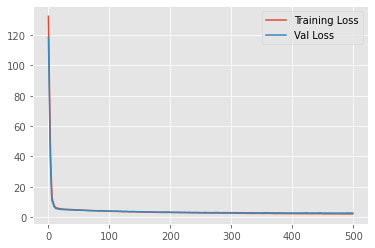

In [ ]:
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Val Loss")
plt.legend()
plt.show()

## 🟡 Make Predictions

In [ ]:
start_time = time.time()

prediction_ResNet50=resnet50_model.predict(test_images_stacked)

end_time =  time.time()

print("prediction_time: ",end_time-start_time )

prediction_time:  0.16037201881408691


In [ ]:
print("MSE: ",MSE_SKL(test_labels, prediction_ResNet50))
print("MAE: ",MAE_SKL(test_labels, prediction_ResNet50))

MSE:  17.02499583037739
MAE:  3.046211333425422


In [ ]:
resnet50_model.save('/kaggle/working/resnet50_3-0-4_loss.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Mean Radial Error for each LandMark along Test Set

In [ ]:
x_coored_ind = np.arange(start=0, stop=38, step=2)
y_coored_ind = np.arange(start=1, stop=39, step=2)

x_true = test_labels[:,x_coored_ind]
y_true = test_labels[:,y_coored_ind]

x_pred = prediction_ResNet50[:,x_coored_ind]
y_pred = prediction_ResNet50[:,y_coored_ind]

radial_error_lm_ex_resnet , mre_each_lm_resnet = (mean_radial_error_landmark(x_true,y_true,x_pred,y_pred))
mre_each_lm_resnet = mre_each_lm_resnet.reshape(19)

50


## Radial Error for each LandMark across 100 test image

Text(0.5, 1.0, 'Radial Error for each LandMark across 100 test image')

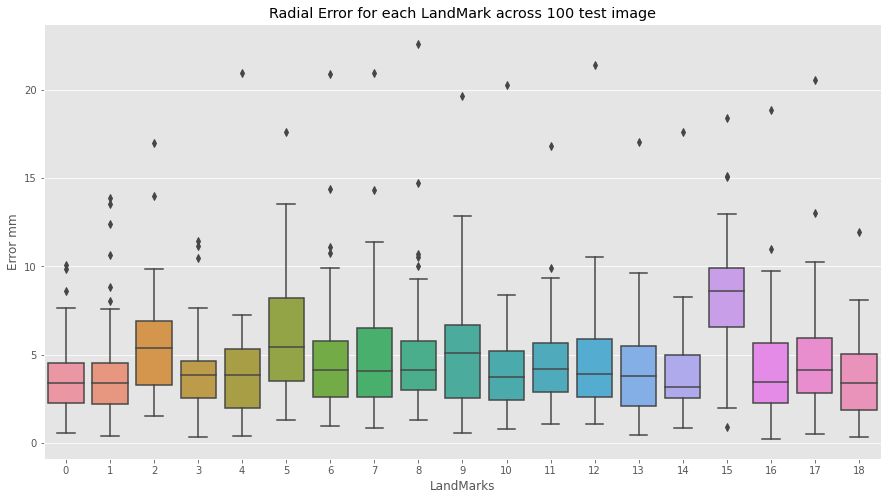

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,8))
sns.boxplot(data = radial_error_lm_ex_resnet[:,:])
plt.xlabel("LandMarks")
plt.ylabel("Error mm")
plt.title("Radial Error for each LandMark across 100 test image")

In [ ]:
delta_x = ( np.subtract(x_true , x_pred) )
delta_x_lm = np.sum(delta_x, axis = 0,keepdims=True)/100
difference_x=(delta_x_lm).reshape(19)

delta_y = ( np.subtract(y_true , y_pred) )
delta_y_lm = np.sum(delta_y, axis = 0,keepdims=True)/100
difference_y =(delta_y_lm).reshape(19)


In [ ]:
import pandas as pd
landmark = np.array(np.arange(1,20),dtype=int)
results = pd.DataFrame({"landmark":landmark,
                        "Mean Radial Error":mre_each_lm_resnet,
                        "X_true - X_pred":difference_x,
                        "y_true - y_pred":difference_y})
results.set_index(['landmark'])
results

,landmark,Mean Radial Error,X_true - X_pred,y_true - y_pred
0,1,3.745386,0.235676,-0.138047
1,2,4.094113,0.276888,0.620100
2,3,5.514654,1.384887,-1.505211
3,4,3.973418,-0.194770,0.233372
4,5,4.011502,0.278442,-0.891144
5,6,6.260099,-0.106664,1.825565
6,7,4.958635,0.189405,-0.222133
7,8,5.207547,0.699665,0.540604
8,9,5.065576,0.457608,-0.418161
9,10,5.144736,0.286468,0.993453


## Mean Radial Error For Each LandMark

<AxesSubplot:>

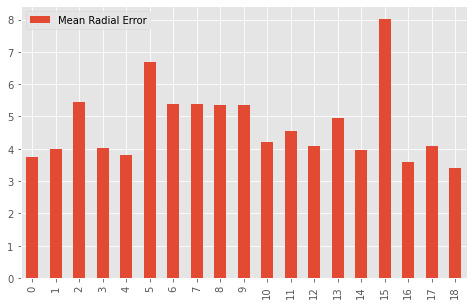

In [ ]:
mre_df = results[["Mean Radial Error"]]
mre_df.plot(kind = "bar",figsize=(8,5))
# mre_df

In [ ]:
def sdr(mre,mre_range):
    return((mre[mre<=mre_range].shape[0])/mre.shape[0])*100

 

In [ ]:
sdr_under_2 = [sdr(radial_error_lm_ex_resnet[:,i],2) for i in range(radial_error_lm_ex_resnet.shape[1])]
sdr_under_2_5 = [sdr(radial_error_lm_ex_resnet[:,i],2.5) for i in range(radial_error_lm_ex_resnet.shape[1])]
sdr_under_3 = [sdr(radial_error_lm_ex_resnet[:,i],3) for i in range(radial_error_lm_ex_resnet.shape[1])]
sdr_under_3_5 = [sdr(radial_error_lm_ex_resnet[:,i],3.5) for i in range(radial_error_lm_ex_resnet.shape[1])]
sdr_under_4 = [sdr(radial_error_lm_ex_resnet[:,i],4) for i in range(radial_error_lm_ex_resnet.shape[1])]

print(f"SDR under 2mm = {sdr_under_2}")
print(f"SDR under 2.5mm = {sdr_under_2_5}")
print(f"SDR under 3mm = {sdr_under_3}")
print(f"SDR under 3.5mm = {sdr_under_3_5}")
print(f"SDR under 4mm = {sdr_under_4}")

SDR under 2mm = [24.0, 22.0, 10.0, 20.0, 26.0, 2.0, 14.000000000000002, 14.000000000000002, 12.0, 20.0, 18.0, 12.0, 14.000000000000002, 24.0, 12.0, 6.0, 20.0, 14.000000000000002, 26.0]
SDR under 2.5mm = [30.0, 30.0, 10.0, 26.0, 32.0, 12.0, 24.0, 24.0, 22.0, 24.0, 26.0, 16.0, 22.0, 34.0, 24.0, 8.0, 28.000000000000004, 16.0, 34.0]
SDR under 3mm = [40.0, 34.0, 18.0, 36.0, 40.0, 14.000000000000002, 28.000000000000004, 30.0, 26.0, 30.0, 34.0, 26.0, 34.0, 36.0, 46.0, 10.0, 42.0, 30.0, 46.0]
SDR under 3.5mm = [52.0, 52.0, 28.000000000000004, 44.0, 44.0, 24.0, 36.0, 40.0, 32.0, 34.0, 42.0, 36.0, 40.0, 42.0, 54.0, 12.0, 50.0, 40.0, 52.0]
SDR under 4mm = [68.0, 68.0, 34.0, 52.0, 54.0, 30.0, 44.0, 48.0, 48.0, 42.0, 56.00000000000001, 48.0, 54.0, 56.00000000000001, 60.0, 16.0, 60.0, 46.0, 66.0]


In [ ]:
# sdr_under_2 = [24.0, 22.0, 10.0, 20.0, 26.0, 2.0, 14.000000000000002, 14.000000000000002, 12.0, 20.0, 18.0, 12.0, 14.000000000000002, 24.0, 12.0, 6.0, 20.0, 14.000000000000002, 26.0]
# sdr_under_2_5 = [30.0, 30.0, 10.0, 26.0, 32.0, 12.0, 24.0, 24.0, 22.0, 24.0, 26.0, 16.0, 22.0, 34.0, 24.0, 8.0, 28.000000000000004, 16.0, 34.0]
# sdr_under_3 = [40.0, 34.0, 18.0, 36.0, 40.0, 14.000000000000002, 28.000000000000004, 30.0, 26.0, 30.0, 34.0, 26.0, 34.0, 36.0, 46.0, 10.0, 42.0, 30.0, 46.0]
# sdr_under_3_5 = [52.0, 52.0, 28.000000000000004, 44.0, 44.0, 24.0, 36.0, 40.0, 32.0, 34.0, 42.0, 36.0, 40.0, 42.0, 54.0, 12.0, 50.0, 40.0, 52.0]
# sdr_under_4 = [68.0, 68.0, 34.0, 52.0, 54.0, 30.0, 44.0, 48.0, 48.0, 42.0, 56.00000000000001, 48.0, 54.0, 56.00000000000001, 60.0, 16.0, 60.0, 46.0, 66.0]
# landmark = np.array(np.arange(1,20),dtype=int)

In [ ]:
sdr_results = pd.DataFrame({"landmark":landmark,
                        "<=2mm":sdr_under_2,
                        "<=2.5mm":sdr_under_2_5,
                        "<=3mm":sdr_under_3,
                        "<=3.5mm":sdr_under_3_5,
                        "<=4mm":sdr_under_4})
sdr_results.set_index(['landmark'])

,<=2mm,<=2.5mm,<=3mm,<=3.5mm,<=4mm
landmark,,,,,
1,24.0,30.0,40.0,52.0,68.0
2,22.0,30.0,34.0,52.0,68.0
3,10.0,10.0,18.0,28.0,34.0
4,20.0,26.0,36.0,44.0,52.0
5,26.0,32.0,40.0,44.0,54.0
6,2.0,12.0,14.0,24.0,30.0
7,14.0,24.0,28.0,36.0,44.0
8,14.0,24.0,30.0,40.0,48.0
9,12.0,22.0,26.0,32.0,48.0


Text(0, 0.5, '% of SDR under 4mm')

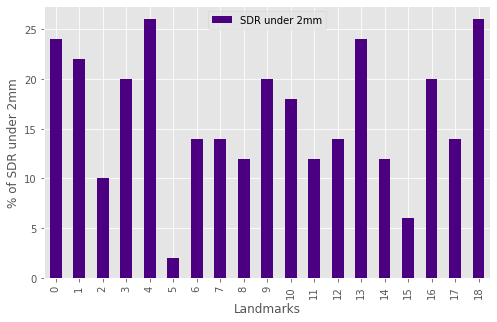

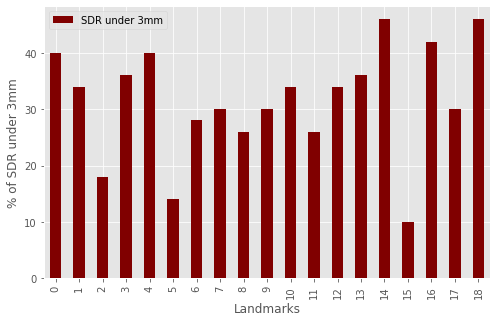

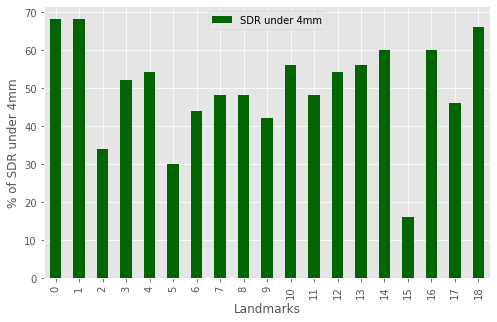

In [ ]:
sdr2_df = sdr_results[["SDR under 2mm"]]
sdr3_df = sdr_results[["SDR under 3mm"]]
sdr4_df = sdr_results[["SDR under 4mm"]]
sdr2_df.plot(kind = "bar",figsize=(8,5),color='indigo')
plt.xlabel('Landmarks')
plt.ylabel('% of SDR under 2mm')
sdr3_df.plot(kind = "bar",figsize=(8,5),color='maroon')
plt.xlabel('Landmarks')
plt.ylabel('% of SDR under 3mm')
sdr4_df.plot(kind = "bar",figsize=(8,5),color='darkgreen')
plt.xlabel('Landmarks')
plt.ylabel('% of SDR under 4mm')